为了让每部分实验更加独立，故将初始化、正则化、梯度校验三部分进行划分独立

### 软件包

In [20]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io as sio
from sympy.abc import theta

plt.rcParams['figure.figsize'] = (7.0, 4.0) # 设置绘图尺寸
plt.rcParams['image.interpolation'] = 'nearest' # 设置图像插值方式，'nearest'表示最近邻插值。插值决定了如何处理图像缩放时的像素值。在图像展示过程中，当需要将图像缩放时，如果没有指定插值方法，matplotlib 会使用默认的插值方式，这里设置为 'nearest'，意味着 每个像素都保持原始大小，直接用最接近的像素值填充，通常用来保证图像的“方块感”。
plt.rcParams['image.cmap'] = 'gray' # 设置图像的默认颜色映射（colormap）。'gray' 表示 灰度图，即显示图像时采用灰度调色板。图像将会根据灰度等级（从黑到白）显示每个像素。如果没有指定其他 colormap，matplotlib 会默认使用灰度调色板来显示图像。
plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号乱码

## 初始化 init_utils

In [2]:
# 用类的方法来写
class init_utils:
    def __init__(self, layers_dims, learning_rate=0.01):
        self.parameters = self.initialize_parameters(layers_dims)
        self.learning_rate = learning_rate

    def initialize_parameters(self, layers_dims):
        # 这里是示例，你需要在这里定义如何根据 layers_dims 来初始化参数
        parameters = {}
        parameters["W1"] = np.random.randn(layers_dims[1], layers_dims[0]) * 0.01
        parameters["b1"] = np.zeros((layers_dims[1], 1))
        parameters["W2"] = np.random.randn(layers_dims[2], layers_dims[1]) * 0.01
        parameters["b2"] = np.zeros((layers_dims[2], 1))
        parameters["W3"] = np.random.randn(layers_dims[3], layers_dims[2]) * 0.01
        parameters["b3"] = np.zeros((layers_dims[3], 1))
        return parameters

    # 计算 sigmoid 激活函数
    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -500, 500) # 防止溢出，避免计算出现 inf 或 nan
        s = 1 / (1 + np.exp(-z))
        return s

    # 计算 relu 激活函数
    @staticmethod
    def relu(z):
        s = np.maximum(0, z) # np.maximum() 逐元素比较 0 和 z 中的每个元素，返回它们中较大的那个。
        return s

    # 计算交叉熵损失
    @staticmethod
    def comput_loss(Y_hat, Y): # Y_hat: 预测值(模型最后一层的输出)，Y: 真实值
        m = Y.shape[1]
        logprobs = np.multiply(-np.log(Y_hat), Y) + np.multiply(-np.log(1 - Y_hat), 1 - Y)
        loss = 1. / m * np.sum(logprobs)
        return loss

    # 实现三层神经网络的前向传播流程
    def forward_propagation(self, X):
        W1, b1 = self.parameters['W1'], self.parameters['b1']
        W2, b2 = self.parameters['W2'], self.parameters['b2']
        W3, b3 = self.parameters['W3'], self.parameters['b3']

        z1 = np.dot(W1, X) + b1
        a1 = self.relu(z1)
        z2 = np.dot(W2, a1) + b2
        a2 = self.relu(z2)
        z3 = np.dot(W3, a2) + b3
        a3 = self.sigmoid(z3)

        cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
        return a3, cache

    # 实现三层神经网络的反向传播流程
    @staticmethod
    def backward_propagation(X, Y, cache):
        (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
        m = X.shape[1]
        dz3 = a3 - Y
        dW3 = np.dot(dz3, a2.T)
        db3 = np.sum(dz3, axis=1, keepdims=True)

        da2 = np.dot(W3.T, dz3)
        dz2 = np.multiply(da2, np.int64(a2 > 0))
        dW2 = np.dot(dz2, a1.T)
        db2 = np.sum(dz2, axis=1, keepdims=True)

        da1 = np.dot(W2.T, dz2)
        dz1 = np.multiply(da1, np.int64(a1 > 0))
        dW1 = np.dot(dz1, X.T)
        db1 = np.sum(dz1, axis=1, keepdims=True)

        gradients = {
            "dZ3": dz3, "dW3": dW3, "db3": db3,
            "da2": da2, "dZ2": dz2, "dW2": dW2, "db2": db2,
            "da1": da1, "dZ1": dz1, "dW1": dW1, "db1": db1
        }

        return gradients

    # 参数更新（梯度下降）
    def update_parameters(self, gradients, learning_rate):
        L = len(self.parameters) // 2
        for l in range(L):
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]

    # 进行预测并计算准确率
    def predict(self, X, y):
        m = X.shape[1]
        p = np.zeros((1, m), dtype=np.int)

        # 前向传播
        Y_hat, caches = self.forward_propagation(X)

        # 第一种写法
        for i in range(Y_hat.shape[1]):
            if Y_hat[0, i] > 0.5:
                p[0, i] = 1
            else:
                p[0, i] = 0

        # 打印预测结果
        print("Accuracy: " + str(np.mean((p[0, :] == y[0, :]))))

        return p

        # 第二种写法
        # p[0, :] = (Y_hat > 0.5).astype(int)
        # print("Accuracy:", np.mean(p == y))
        # return p

    # 生成一个带噪声的“圆形”数据集, 这是一个二分类任务，用于验证神经网络的非线性分类能力
    @staticmethod
    def load_dataset(is_plot=True):
        np.random.seed(1) # 设置随机种子为 1，保证每次生成的数据集都是相同的。用于训练集
        train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
        """
        使用 sklearn 中的 make_circles 函数生成一个二分类的同心圆形数据集（即两类数据分布在两个圆上），
            train_X：维度是 (300, 2)，即 300 个样本，每个样本是二维点 (x1, x2)
            train_Y：维度是 (300,)，每个样本的标签（0 或 1）
        """
        np.random.seed(2) # 重新设置随机种子为 2，以生成 不同于训练集 的测试集。
        test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)

        # 是否需要绘制
        if is_plot:
            plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral)

        train_X = train_X.T
        train_Y = train_Y.reshape((1, train_Y.shape[0]))
        test_X = test_X.T
        test_Y = test_Y.reshape((1, test_Y.shape[0]))

        return train_X, train_Y, test_X, test_Y

    # 可视化分类边界
    @staticmethod
    def plot_decision_boundary(model, X, y):
        # 设置边界
        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
        h = 0.01

        # 生成网格
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # 预测整个网格的函数值
        Z = model(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # 绘制图像
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
        plt.show()

    # 辅助绘图函数，预测每个点属于哪一类（用于画边界） 返回：0/1 的布尔数组
    def predict_dec(self, X):
        # 使用前向传播计算最终输出
        Y_hat, cache = self.forward_propagation(X.T) # 这里用了X.T
        predictions = (Y_hat > 0.5)
        return predictions

        """
            这个函数是为了配合 plot_decision_boundary() 函数使用的，它不会打印准确率，也不返回概率，而是直接将预测值进行 0/1 分类。
            在绘制决策边界时，每个网格点坐标都会作为 X 传进来，predict_dec 会判断它属于哪一类（0 或 1），从而用颜色进行区分。
        """

# init_utils.load_dataset(is_plot=True)

### 正则化 reg_utils

(array([[-1.58986e-01, -3.47926e-01, -5.04608e-01, -5.96774e-01,
         -5.18433e-01, -2.92627e-01, -1.58986e-01, -5.76037e-02,
         -7.14286e-02, -2.97235e-01, -4.17051e-01, -4.40092e-01,
         -3.24885e-01, -2.46544e-01, -2.18894e-01, -3.43318e-01,
         -5.09217e-01, -3.84793e-01, -1.49770e-01, -1.95853e-01,
         -3.91705e-02, -1.08295e-01, -1.86636e-01, -2.18894e-01,
         -8.06452e-02,  6.68203e-02,  9.44700e-02,  1.86636e-01,
          6.22120e-02,  2.07373e-02,  2.99539e-02, -9.90783e-02,
         -6.91244e-03,  1.31336e-01,  2.32719e-01,  8.52535e-02,
         -1.31336e-01,  2.30415e-03,  1.22120e-01, -3.47926e-01,
         -2.28111e-01, -7.60369e-02,  4.37788e-02,  1.15207e-02,
         -4.17051e-01, -3.15668e-01,  1.26728e-01,  2.05069e-01,
          2.18894e-01,  7.14286e-02, -1.31336e-01, -2.09677e-01,
         -2.28111e-01, -1.45161e-01, -6.68203e-02,  1.35945e-01,
          2.69585e-01,  2.97235e-01,  2.74194e-01,  2.55760e-01,
          2.23502e-01,  1

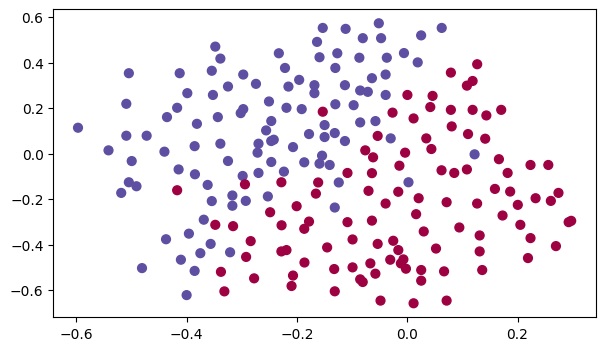

In [3]:
class reg_utils:
    def __init__(self, parameters, learning_rate=0.01, layers_dims = [2, 3, 2, 1]):
        self.learning_rate = learning_rate
        self.layers_dims = layers_dims
        self.parameters = {}

    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -500, 500)
        s = 1 / (1 + np.exp(-z))
        return s

    @staticmethod
    def relu(z):
        s = np.maximum(0, z)
        return s

    def initialize_parameters(self):
        np.random.seed(3)
        L = len(self.layers_dims) // 2

        for l in range(1, L):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_dims[l], self.layers_dims[l - 1]) / np.sqrt(self.layers_dims[l - 1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_dims[l], 1))

            # 断言
            assert(self.parameters["W" + str(l)].shape == (self.layers_dims[l], self.layers_dims[l - 1]))
            assert(self.parameters["b" + str(l)].shape == (self.layers_dims[l], 1))

        return self.parameters

    def forward_propagation(self, X):
        W1 = self.parameters["W1"]
        b1 = self.parameters["b1"]
        W2 = self.parameters["W2"]
        b2 = self.parameters["b2"]
        W3 = self.parameters["W3"]
        b3 = self.parameters["b3"]

        z1 = np.dot(W1, X) + b1
        a1 = self.tanh(z1)
        z2 = np.dot(W2, a1) + b2
        a2 = self.tanh(z2)
        z3 = np.dot(W3, a2) + b3
        a3 = self.sigmoid(z3)

        cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)

        return a3, cache

    @staticmethod
    def computer_cost(Y_hat, Y):
        m = Y.shape[1]
        logprobs = np.multiply(np.log(Y_hat), Y) + np.multiply(np.log(1 - Y_hat), (1 - Y))
        cost = - np.sum(logprobs) / m

        return cost

    @staticmethod
    def backward_propagation(X, Y, cache):
        (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
        m = X.shape[1]
        dz3 = a3 - Y
        dW3 = np.dot(dz3, a2.T)
        db3 = np.sum(dz3, axis=1, keepdims=True)

        da2 = np.dot(W3.T, dz3)
        dz2 = np.multiply(da2, np.int64(a2 > 0))
        dW2 = np.dot(dz2, a1.T)
        db2 = np.sum(dz2, axis=1, keepdims=True)

        da1 = np.dot(W2.T, dz2)
        dz1 = np.multiply(da1, np.int64(a1 > 0))
        dW1 = np.dot(dz1, X.T)
        db1 = np.sum(dz1, axis=1, keepdims=True)

        gradients = {
            "dZ3": dz3, "dW3": dW3, "db3": db3,
            "da2": da2, "dZ2": dz2, "dW2": dW2, "db2": db2,
            "da1": da1, "dZ1": dz1, "dW1": dW1, "db1": db1
        }

        return gradients

    def update_parameters(self, gradients, learning_rate):
        L = len(self.parameters) // 2
        for l in range(L):
            self.parameters["W" + str(l + 1)] = self.parameters["W" + str(l + 1)] - learning_rate * gradients["dW" + str(l + 1)]
            self.parameters["b" + str(l + 1)] = self.parameters["b" + str(l + 1)] - learning_rate * gradients["db" + str(l + 1)]

    # 加载数据集
    @staticmethod
    def load_2D_dataset(is_plot=False):
        data = sio.loadmat('../datasets/data.mat')
        train_X = data['X'].T
        train_Y = data['y'].T
        test_X = data['Xval'].T
        test_Y = data['yval'].T
        if is_plot:
            plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral)
        return train_X, train_Y, test_X, test_Y

    def predict(self, X, y):
        m = X.shape[1]
        p = np.zeros((1, m), dtype=np.int)

        # 前向传播
        Y_hat, caches = self.forward_propagation(X)

        # 第一种写法
        for i in range(Y_hat.shape[1]):
            if Y_hat[0, i] > 0.5:
                p[0, i] = 1
            else:
                p[0, i] = 0

        # 打印预测结果
        print("Accuracy: " + str(np.mean((p[0, :] == y[0, :]))))

        return p

        # 第二种写法
        # p[0, :] = (Y_hat > 0.5).astype(int)
        # print("Accuracy:", np.mean(p == y))
        # return p

    @staticmethod
    def plot_decision_boundary(model, X, y):
        # 设置边界
        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
        h = 0.01

        # 生成网格
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

        # 预测整个网格的函数值
        Z = model(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # 绘制图像
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
        plt.show()

    # 辅助绘图函数，预测每个点属于哪一类（用于画边界） 返回：0/1 的布尔数组
    def predict_dec(self, X):
        # 使用前向传播计算最终输出
        Y_hat, cache = self.forward_propagation(X.T) # 这里用了X.T
        predictions = (Y_hat > 0.5)
        return predictions

reg_utils.load_2D_dataset(is_plot=True)


### 梯度检验 gc_utils

In [4]:
class gc_utils:
    def __init__(self, parameters):
        self.parameters = parameters

    @staticmethod
    def sigmoid(z):
        z = np.clip(z, -500, 500)
        s = 1 / (1 + np.exp(-z))
        return s

    @staticmethod
    def relu(z):
        s = np.maximum(0, z)
        return s

    # 字典与向量转换函数
    # 计算“数值梯度”时要对整个参数向量进行扰动，这个函数完成“展平”。
    def dictionary_to_vector(self):
        """
        你有一个三层的神经网络：
            第 1 层：输入 4 个神经元 → 输出 5 个神经元，所以：
                W1：shape = (5, 4)
                b1：shape = (5, 1)
            第 2 层：5 → 3
                W2：shape = (3, 5)
                b2：shape = (3, 1)
            第 3 层：3 → 1
                W3：shape = (1, 3)
                b3：shape = (1, 1)
            所以这个神经网络总参数量 = 5×4 + 5 + 3×5 + 3 + 1×3 + 1 = 47 个元素。
        """
        # 将参数字典（每层的权重和偏置）拉平成一个大向量，便于数值梯度计算时统一处理。
        keys = [] # 保存参数来源的键（例如：W1、b1），方便调试。
        count = 0
        for key in ['W1', 'b1', 'W2', 'b2', 'W3', 'b3']:
            new_vector = np.reshape(self.parameters[key], (-1, 1))
            keys = keys + [key] * new_vector.shape[0]

            if count == 0:
                theta = new_vector # 如果是第一个参数，就直接赋值给 theta，因为这时候还没有已有的列向量可以拼接。
            else:
                theta = np.concatenate((theta, new_vector), axis=0) # 把当前这个参数 new_vector 沿着第0轴（也就是“竖着”）拼接到原有的 theta 后面，形成一个更长的列向量。
            count += 1

        return theta, keys

    def vector_to_dictionary(self, theta):

        """
            作用：把拉平（flatten）成向量的参数 theta，重新还原成一个结构化的字典形式，包含各层的权重（W）和偏置（b）。
            梯度检验过程中，将数值梯度 theta 还原成可用于前向/反向传播的参数形式。

        :param theta:
        :return:
        """
        self.parameters = {}  # 重新构造字典
        self.parameters["W1"] = theta[:20].reshape((5, 4))
        self.parameters["b1"] = theta[20:25].reshape((5, 1))
        self.parameters["W2"] = theta[25:40].reshape((3, 5))
        self.parameters["b2"] = theta[40:43].reshape((3, 1))
        self.parameters["W3"] = theta[43:46].reshape((1, 3))
        self.parameters["b3"] = theta[46:47].reshape((1, 1))

        return self.parameters

    # def test_dictionary_to_vector(self):
    #     theta, keys = self.dictionary_to_vector()
    #     print("✅ 测试 dictionary_to_vector()")
    #     print("theta shape:", theta.shape)
    #     print("theta:\n", theta)
    #     print("\nkeys length:", len(keys))
    #     print("keys:\n", keys)
    #     return theta  # 注意：我们返回 theta 以供下一步测试用
    #
    # def test_vector_to_dictionary(self, theta):
    #     parameters = self.vector_to_dictionary(theta)
    #     print("\n✅ 测试 vector_to_dictionary()")
    #     for key in parameters:
    #         print(f"{key}: shape = {parameters[key].shape}")
    #         print(parameters[key], "\n")

    def gradients_to_vector(self, gradients):
        """
        将梯度字典（每层的权重和偏置的导数）展开成一个列向量，用于梯度检验。
        """
        count = 0
        for key in ['dW1', 'db1', 'dW2', 'db2', 'dW3', 'db3']:
            new_vector = np.reshape(gradients[key], (-1, 1))

            if count == 0:
                theta = new_vector
            else:
                theta = np.concatenate((theta, new_vector), axis=0)
            count = count + 1
        return theta

    # def test_gradients_to_verctor(self, gradients):
    #     theta = self.gradients_to_vector(gradients)
    #     print("✅ 测试 gradients_to_vector()")
    #     print("theta shape:", theta.shape)
    #     print("theta:\n", theta)


# # 测试
# parameters = {
#     "W1": np.random.randn(5, 4),
#     "b1": np.random.randn(5, 1),
#     "W2": np.random.randn(3, 5),
#     "b2": np.random.randn(3, 1),
#     "W3": np.random.randn(1, 3),
#     "b3": np.random.randn(1, 1)
# }
# gradients = {
#     "dW1": np.random.randn(5, 4),
#     "db1": np.random.randn(5, 1),
#     "dW2": np.random.randn(3, 5),
#     "db2": np.random.randn(3, 1),
#     "dW3": np.random.randn(1, 3),
#     "db3": np.random.randn(1, 1)
# }
#
# # 实例化对象
# utils = gc_utils(parameters)

# 执行测试
# theta = utils.test_dictionary_to_vector()
# utils.test_vector_to_dictionary(theta)
# utils.test_gradients_to_verctor(gradients)


In [17]:
# 三种初始化类型
class InitializeParameters:
    def __init__(self, layers_dims):
        self.layers_dims = layers_dims
        self.parameters = {}
        self.L = len(layers_dims)

    # 第一种类型：初始化为0
    def initialize_parameters_zeros(self):
        """
        将模型的参数全部设置为0

        参数：
            layers_dims - 列表，模型的层数和对应每一层的节点的数量
        返回
            parameters - 包含了所有W和b的字典
                W1 - 权重矩阵，维度为（layers_dims[1], layers_dims[0]）
                b1 - 偏置向量，维度为（layers_dims[1],1）
                ···
                WL - 权重矩阵，维度为（layers_dims[L], layers_dims[L -1]）
                bL - 偏置向量，维度为（layers_dims[L],1）
        """
        for l in range(1, self.L):
            self.parameters["W" + str(l)] = np.zeros((self.layers_dims[l], self.layers_dims[l-1]))
            self.parameters["b" + str(l)] = np.zeros((self.layers_dims[l], 1))

            # 断言
            assert self.parameters["W" + str(l)].shape == (self.layers_dims[l], self.layers_dims[l-1])
            assert self.parameters["b" + str(l)].shape == (self.layers_dims[l], 1)

        return self.parameters

    # 第二种类型：随机初始化
    def initialize_parameters_random(self):
        np.random.seed(3)
        for l in range(1, self.L):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_dims[l], self.layers_dims[l-1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_dims[l], 1))

            # 断言
            assert self.parameters["W" + str(l)].shape == (self.layers_dims[l], self.layers_dims[l-1])
            assert self.parameters["b" + str(l)].shape == (self.layers_dims[l], 1)

        return self.parameters

    # 第三种类型：抑梯度异常初始化
    def initialize_parameters_he(self):
        np.random.seed(3)
        for l in range(1, self.L):
            self.parameters["W" + str(l)] = np.random.randn(self.layers_dims[l], self.layers_dims[l-1]) * np.sqrt(2 / self.layers_dims[l-1])
            self.parameters["b" + str(l)] = np.zeros((self.layers_dims[l], 1))

            # 断言
            assert self.parameters["W" + str(l)].shape == (self.layers_dims[l], self.layers_dims[l-1])
            assert self.parameters["b" + str(l)].shape == (self.layers_dims[l], 1)

        return self.parameters

# 测试
layer_dims = [2, 4, 1]
initialize_parameters = InitializeParameters(layer_dims)
# parameters = initialize_parameters.initialize_parameters_zeros()
# parameters = initialize_parameters.initialize_parameters_random()
parameters = initialize_parameters.initialize_parameters_he()
print(type(parameters))
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

<class 'dict'>
W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
b2 = [[0.]]


1. 初始化参数：
	1.1：使用0来初始化参数。
	1.2：使用随机数来初始化参数。
	1.3：使用抑梯度异常初始化参数（参见梯度消失和梯度爆炸章节部分）。
2. 正则化模型：
	2.1：使用二范数对二分类模型正则化，尝试避免过拟合。
	2.2：使用随机删除节点的方法精简模型，同样是为了尝试避免过拟合。
3. 梯度校验  ：对模型使用梯度校验，检测它是否在梯度下降的过程中出现误差过大的情况。

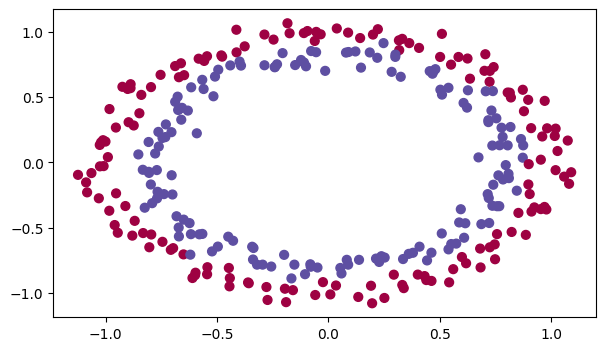

In [6]:
## 读取并绘制数据
train_X, train_Y, test_X, test_Y = init_utils.load_dataset(is_plot=True)

我们将要建立一个分类器把蓝点和红点分开，在之前我们已经实现过一个3层的神经网络，我们将对它进行初始化：

我们将会尝试下面三种初始化方法:

- 初始化为0：在输入参数中全部初始化为0，参数名为initialization = “zeros”，核心代码：`parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l - 1]))`

- 初始化为随机数：把输入参数设置为随机值，权重初始化为大的随机值。参数名为initialization = “random”，核心代码：`parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * 10`

- 抑梯度异常初始化：参见梯度消失和梯度爆炸的那一个视频，参数名为initialization = “he”，核心代码：`parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l - 1]) * np.sqrt(2 / layers_dims[l - 1])`

首先来看看模型是怎样的：

In [18]:
def model(X, Y, learning_rate=0.01, num_iterations=30000, print_cost=True, initialization="he", is_plot=True):
    """
    实现一个三层的神经网络：LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID

    参数：
        X - 输入数据，shape: (特征数, 样本数)
        Y - 标签向量，shape: (1, 样本数)
        learning_rate - 学习率
        num_iterations - 训练迭代次数
        print_cost - 是否打印损失
        initialization - 初始化方法："zeros" | "random" | "he"
        is_plot - 是否绘制成本图像

    返回：
        parameters - 训练好的参数字典
    """
    np.random.seed(1)
    grads = []
    costs = []
    layers_dims = [X.shape[0], 10, 5, 1]

    # 选择初始化器
    initializer = InitializeParameters(layers_dims)
    if initialization == "zeros":
        parameters = initializer.initialize_parameters_zeros()
    elif initialization == "random":
        parameters = initializer.initialize_parameters_random()
    elif initialization == "he":
        parameters = initializer.initialize_parameters_he()
    else:
        raise ValueError("初始化方法错误，只能是 'zeros'、'random' 或 'he'")

    # 创建工具对象
    net = init_utils(layers_dims, learning_rate)
    net.parameters = parameters  # 覆盖初始化参数

    # 开始训练
    for i in range(num_iterations):
        a3, cache = net.forward_propagation(X)
        cost = net.comput_loss(a3, Y)
        grads = net.backward_propagation(X, Y, cache)
        net.update_parameters(grads, learning_rate)

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"第{i}次迭代，成本值为：{cost:.6f}")

    # 成本图像
    if is_plot:
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (每100次)')
        plt.title(f"Learning rate = {learning_rate}")
        plt.grid()
        plt.show()

    return net.parameters


第0次迭代，成本值为：1.969819
第100次迭代，成本值为：0.693147
第200次迭代，成本值为：0.693147
第300次迭代，成本值为：0.693147
第400次迭代，成本值为：0.693147
第500次迭代，成本值为：0.693147
第600次迭代，成本值为：0.693147
第700次迭代，成本值为：0.693147
第800次迭代，成本值为：0.693147
第900次迭代，成本值为：0.693147
第1000次迭代，成本值为：0.693147
第1100次迭代，成本值为：0.693147
第1200次迭代，成本值为：0.693147
第1300次迭代，成本值为：0.693147
第1400次迭代，成本值为：0.693147
第1500次迭代，成本值为：0.693147
第1600次迭代，成本值为：0.693147
第1700次迭代，成本值为：0.693147
第1800次迭代，成本值为：0.693147
第1900次迭代，成本值为：0.693147
第2000次迭代，成本值为：0.693147
第2100次迭代，成本值为：0.693147
第2200次迭代，成本值为：0.693147
第2300次迭代，成本值为：0.693147
第2400次迭代，成本值为：0.693147
第2500次迭代，成本值为：0.693147
第2600次迭代，成本值为：0.693147
第2700次迭代，成本值为：0.693147
第2800次迭代，成本值为：0.693147
第2900次迭代，成本值为：0.693147
第3000次迭代，成本值为：0.693147
第3100次迭代，成本值为：0.693147
第3200次迭代，成本值为：0.693147
第3300次迭代，成本值为：0.693147
第3400次迭代，成本值为：0.693147
第3500次迭代，成本值为：0.693147
第3600次迭代，成本值为：0.693147
第3700次迭代，成本值为：0.693147
第3800次迭代，成本值为：0.693147
第3900次迭代，成本值为：0.693147
第4000次迭代，成本值为：0.693147
第4100次迭代，成本值为：0.693147
第4200次迭代，成本值为：0.693147
第4300次迭代，成本值为：0.693147


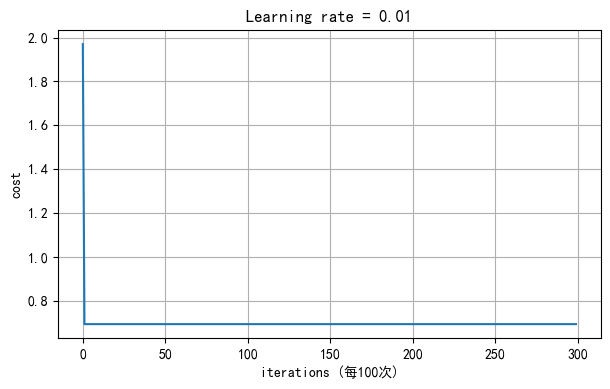

In [25]:
# 采用第一种初始化测试
parameters = model(train_X, train_Y, learning_rate=0.01, num_iterations=30000, print_cost=True, initialization="random", is_plot=True)
